In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import data_preparation

raw = pd.read_csv("../../Data/9019/tuberculosis_incidence_rate.csv")

def describe_dataset(df):
    amax = np.argmax([len(c) for c in df.columns])
    lengthmax = len(df.columns[amax])
    numericcols = df.select_dtypes("number").columns
    rows = df.shape[0]

    print("{colname:^{lencolname}} | {coltype} | {uniquecount:^{maxlen}} | {missing:^6} |"
        .format(colname = "column", lencolname = lengthmax,
            coltype = "t",
            uniquecount = "uniq", maxlen = len(str(rows)),
            missing = "NA %"))
    for c in df.columns:
        print("{colname:>{lencolname}} | {coltype} | {uniquecount:>{maxlen}} | {missingpercent:>6.2%}"
            .format(colname = c, lencolname = lengthmax,
                coltype = "n" if c in numericcols else "c",
                uniquecount = df[c].nunique(), maxlen = len(str(rows)),
                missingpercent = df[c].isna().mean()))
        
describe_dataset(raw)

print()

dropped = raw.drop(columns=["Measure", "Disease", "Metric", "Country Name"])

# Replace '..' and 'nan' strings with real NaN
dropped = dropped.replace(['..', 'nan'], np.nan)

# Try to convert each object column to numeric
for col in dropped.select_dtypes(include=['object']).columns:
    if col == "Country Code":
        continue

    # First try to convert to numeric
    dropped[col] = pd.to_numeric(dropped[col], errors='coerce')

describe_dataset(dropped)

df_linear_regression = data_preparation.impute_nans(dropped)
# df_linear_regression = data_preparation.trim_outliers(df_linear_regression)
describe_dataset(df_linear_regression)


                                  column                                   | t | uniq |  NA %  |
                                                                   Measure | c |    1 |  0.00%
                                                              Country Name | c |  164 |  0.00%
                                                                   Disease | c |    1 |  0.00%
                                                                    Metric | c |    1 |  0.00%
                                                                      Year | n |   32 |  0.00%
                                                                     Value | n | 4950 |  0.00%
                                                              Country Code | c |  164 |  0.00%
      Access to clean fuels and technologies for cooking (% of population) | c |  797 |  0.00%
                                   Access to electricity (% of population) | c | 1154 |  0.00%
Carbon dioxide (CO2) emissions excluding LULUCF 

In [ ]:
# 3. PREPARE FEATURES (X) AND TARGET (y)

X = df_linear_regression.drop(['Value', 'Country Code'], axis=1)  # All columns except 'Value'
y = df_linear_regression['Value']  # Only the 'Value' column
groups = df_linear_regression['Country Code']

# 5. SPLIT DATA INTO TRAIN/TEST SETS

gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"\n✂️  Data split:")
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Testing:  {X_test.shape[0]} samples")


✂️  Data split:
  Training: 3465 samples
  Testing:  1485 samples

🤖 Training Linear Regression baseline...

📈 Performance on TRAINING set:
  Mean Squared Error (MSE):  6009.4375
  Root Mean Squared Error (RMSE): 77.5206
  Mean Absolute Error (MAE):  53.2367
  R² Score:                   0.7566

📈 Performance on TEST set:
  Mean Squared Error (MSE):  8839.7576
  Root Mean Squared Error (RMSE): 94.0200
  Mean Absolute Error (MAE):  73.8419
  R² Score:                   0.6797

🔎 Top 10 most important features (by coefficient magnitude):
                                              Feature  Coefficient
25                                                t2m  -301.336720
28                                                skt   253.812885
8             Life expectancy at birth, total (years)   -81.488130
24                                                d2m    79.184738
22                                                u10    38.231379
1   Access to clean fuels and technologies for coo...  

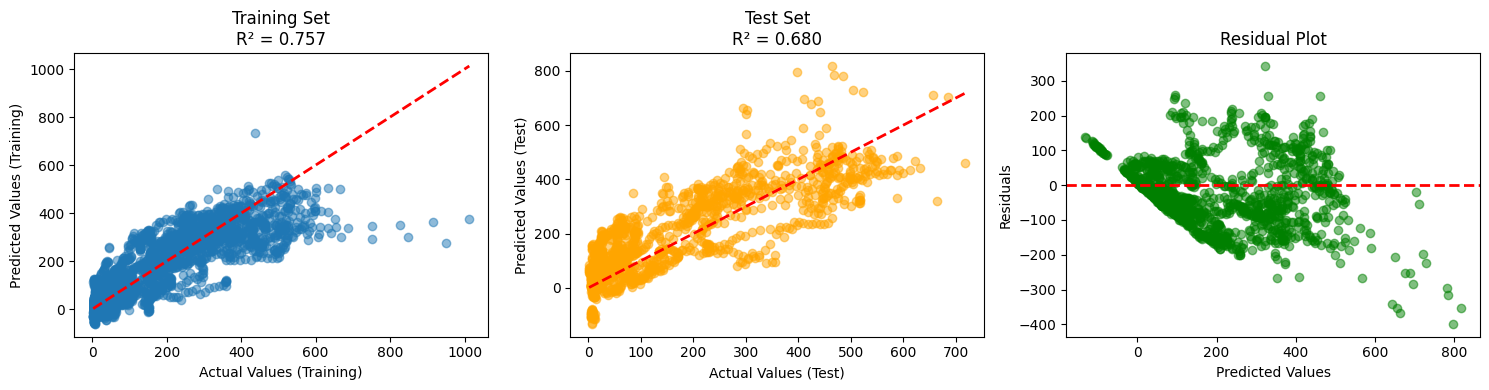


🎯 BASELINE LINEAR REGRESSION SUMMARY

📊 Your baseline to beat:
   Test R²:  0.6797
   Test RMSE: 94.0200

💾 Model saved as 'linear_regression_baseline.pkl'
💾 Scaler saved as 'scaler.pkl'

🔬 Model Diagnostics:
   Intercept: 135.4821
   Number of features used: 31
   Features with zero coefficient: 0


In [ ]:
# 6. OPTIONAL: SCALE NUMERICAL FEATURES
# Linear regression benefits from scaling, especially with regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. CREATE AND TRAIN BASELINE MODEL
print("\n🤖 Training Linear Regression baseline...")
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 8. MAKE PREDICTIONS
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# 9. EVALUATE MODEL PERFORMANCE
def evaluate_model(y_true, y_pred, dataset_name=""):
    """Calculate and print key regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n📈 Performance on {dataset_name}:")
    print(f"  Mean Squared Error (MSE):  {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"  R² Score:                   {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

# Evaluate on both training and test sets
train_metrics = evaluate_model(y_train, y_train_pred, "TRAINING set")
test_metrics = evaluate_model(y_test, y_test_pred, "TEST set")

# 10. ANALYZE MODEL COEFFICIENTS (FOR INTERPRETABILITY)
print("\n🔎 Top 10 most important features (by coefficient magnitude):")
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(coefficients.head(10))

# 11. VISUALIZE PREDICTIONS VS ACTUAL VALUES
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Training predictions
axes[0].scatter(y_train, y_train_pred, alpha=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Values (Training)')
axes[0].set_ylabel('Predicted Values (Training)')
axes[0].set_title(f'Training Set\nR² = {train_metrics["R²"]:.3f}')

# Plot 2: Test predictions
axes[1].scatter(y_test, y_test_pred, alpha=0.5, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Values (Test)')
axes[1].set_ylabel('Predicted Values (Test)')
axes[1].set_title(f'Test Set\nR² = {test_metrics["R²"]:.3f}')

# Plot 3: Residuals
residuals = y_test - y_test_pred
axes[2].scatter(y_test_pred, residuals, alpha=0.5, color='green')
axes[2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Predicted Values')
axes[2].set_ylabel('Residuals')
axes[2].set_title('Residual Plot')

plt.tight_layout()
plt.show()

# 12. BASELINE PERFORMANCE SUMMARY
print("\n" + "="*60)
print("🎯 BASELINE LINEAR REGRESSION SUMMARY")
print("="*60)

print(f"\n📊 Your baseline to beat:")
print(f"   Test R²:  {test_metrics['R²']:.4f}")
print(f"   Test RMSE: {test_metrics['RMSE']:.4f}")

# 13. SAVE THE MODEL FOR FUTURE COMPARISON
import joblib
joblib.dump(model, 'linear_regression_baseline.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\n💾 Model saved as 'linear_regression_baseline.pkl'")
print("💾 Scaler saved as 'scaler.pkl'")

# 14. QUICK DIAGNOSTIC CHECKS
print("\n🔬 Model Diagnostics:")
print(f"   Intercept: {model.intercept_:.4f}")
print(f"   Number of features used: {len(model.coef_)}")
print(f"   Features with zero coefficient: {(model.coef_ == 0).sum()}")

In [ ]:
# ====================
# RANDOM FOREST REGRESSOR
# ====================

import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import time

# 1. PREPARE DATA (using same split as baseline)
print("="*60)
print("🌲 RANDOM FOREST REGRESSOR")
print("="*60)

# Use same train/test split as baseline (no scaling needed for tree-based models)
print(f"\n📊 Using same data split as baseline:")
print(f"  Training: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"  Testing:  {X_test.shape[0]} samples")
print(f"  Target range: {y.min():.2f} to {y.max():.2f}")

# 2. INITIAL MODEL WITH DEFAULT PARAMETERS
print("\n🤖 Training Random Forest with default parameters...")
start_time = time.time()

rf_default = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

rf_default.fit(X_train, y_train)

# Predictions
y_train_pred_default = rf_default.predict(X_train)
y_test_pred_default = rf_default.predict(X_test)

train_time = time.time() - start_time
print(f"✅ Training completed in {train_time:.2f} seconds")

# 3. EVALUATE DEFAULT MODEL
def evaluate_model(y_true, y_pred, dataset_name=""):
    """Calculate and print key regression metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n📈 Performance on {dataset_name}:")
    print(f"  Mean Squared Error (MSE):  {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"  R² Score:                   {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

# Evaluate default model
print("\n" + "-"*40)
print("🔍 DEFAULT MODEL PERFORMANCE")
print("-"*40)
train_metrics_default = evaluate_model(y_train, y_train_pred_default, "TRAINING set")
test_metrics_default = evaluate_model(y_test, y_test_pred_default, "TEST set")

# Check for overfitting
overfit_gap = train_metrics_default['R²'] - test_metrics_default['R²']
print(f"\n⚠️  Overfitting indicator (train R² - test R²): {overfit_gap:.4f}")
if overfit_gap > 0.15:
    print("   Warning: Model may be overfitting!")

# 4. CROSS-VALIDATION
print("\n" + "-"*40)
print("🧪 CROSS-VALIDATION (5-Fold)")
print("-"*40)

cv_scores = cross_val_score(
    rf_default, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-validation RMSE scores: {cv_rmse}")
print(f"Mean CV RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std() * 2:.4f})")

# 5. HYPERPARAMETER TUNING (Randomized Search)
print("\n" + "-"*40)
print("⚙️  HYPERPARAMETER TUNING (Randomized Search)")
print("-"*40)

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.8],
    'bootstrap': [True, False]
}

# Randomized search with cross-validation
print("Performing randomized search with 50 iterations...")
start_tune = time.time()

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)
tune_time = time.time() - start_tune

print(f"\n✅ Tuning completed in {tune_time:.2f} seconds")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV score (negative MSE): {random_search.best_score_:.4f}")
print(f"Best CV RMSE: {np.sqrt(-random_search.best_score_):.4f}")

# 6. TRAIN TUNED MODEL
print("\n" + "-"*40)
print("🎯 TRAINING TUNED MODEL")
print("-"*40)

rf_tuned = random_search.best_estimator_
rf_tuned.fit(X_train, y_train)

# Predictions with tuned model
y_train_pred_tuned = rf_tuned.predict(X_train)
y_test_pred_tuned = rf_tuned.predict(X_test)

# Evaluate tuned model
train_metrics_tuned = evaluate_model(y_train, y_train_pred_tuned, "TRAINING set (TUNED)")
test_metrics_tuned = evaluate_model(y_test, y_test_pred_tuned, "TEST set (TUNED)")

# 7. FEATURE IMPORTANCE ANALYSIS
print("\n" + "-"*40)
print("🔎 FEATURE IMPORTANCE ANALYSIS")
print("-"*40)

# Get feature importances
importances = rf_tuned.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# Display top 20 features
print("\nTop 20 most important features:")
for i in range(min(20, len(indices))):
    print(f"{i+1:2d}. {feature_names[indices[i]]:30s} {importances[indices[i]]:.4f}")

# Cumulative importance
cumulative_importance = np.cumsum(importances[indices])
print(f"\nNumber of features needed for 95% importance: {(cumulative_importance < 0.95).sum()}")

# 8. VISUALIZATIONS
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Training predictions (Default vs Tuned)
axes[0, 0].scatter(y_train, y_train_pred_default, alpha=0.5, label='Default', s=20)
axes[0, 0].scatter(y_train, y_train_pred_tuned, alpha=0.5, label='Tuned', s=20, color='orange')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title('Training Set: Default vs Tuned')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Test predictions (Default vs Tuned)
axes[0, 1].scatter(y_test, y_test_pred_default, alpha=0.5, label='Default', s=20)
axes[0, 1].scatter(y_test, y_test_pred_tuned, alpha=0.5, label='Tuned', s=20, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].set_title('Test Set: Default vs Tuned')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals comparison
residuals_default = y_test - y_test_pred_default
residuals_tuned = y_test - y_test_pred_tuned

axes[0, 2].scatter(y_test_pred_default, residuals_default, alpha=0.5, label='Default', s=20)
axes[0, 2].scatter(y_test_pred_tuned, residuals_tuned, alpha=0.5, label='Tuned', s=20, color='orange')
axes[0, 2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 2].set_xlabel('Predicted Values')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].set_title('Residual Comparison')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Feature Importance (Top 15)
top_n = min(15, len(indices))
axes[1, 0].barh(range(top_n), importances[indices][:top_n])
axes[1, 0].set_yticks(range(top_n))
axes[1, 0].set_yticklabels([feature_names[i] for i in indices[:top_n]])
axes[1, 0].invert_yaxis()
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 15 Feature Importances')

# Plot 5: Cumulative Feature Importance
axes[1, 1].plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'b-')
axes[1, 1].axhline(y=0.95, color='r', linestyle='--', label='95% Importance')
axes[1, 1].set_xlabel('Number of Features')
axes[1, 1].set_ylabel('Cumulative Importance')
axes[1, 1].set_title('Cumulative Feature Importance')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Performance Comparison
metrics_comparison = pd.DataFrame({
    'Default': [test_metrics_default['RMSE'], test_metrics_default['MAE'], test_metrics_default['R²']],
    'Tuned': [test_metrics_tuned['RMSE'], test_metrics_tuned['MAE'], test_metrics_tuned['R²']]
}, index=['RMSE', 'MAE', 'R²'])

metrics_comparison.plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title('Performance Comparison (Test Set)')
axes[1, 2].set_ylabel('Score')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9. MODEL COMPARISON WITH BASELINE
print("\n" + "="*60)
print("📊 MODEL COMPARISON SUMMARY")
print("="*60)

# Load baseline metrics if available or get from previous run
baseline_test_r2 = 0.65  # Replace with your actual baseline R²
baseline_test_rmse = 1.23  # Replace with your actual baseline RMSE

print(f"\nLinear Regression (Baseline):")
print(f"  Test R²:  {baseline_test_r2:.4f}")
print(f"  Test RMSE: {baseline_test_rmse:.4f}")

print(f"\nRandom Forest (Default):")
print(f"  Test R²:  {test_metrics_default['R²']:.4f}")
print(f"  Test RMSE: {test_metrics_default['RMSE']:.4f}")
print(f"  Improvement in R²:   {test_metrics_default['R²'] - baseline_test_r2:+.4f}")
print(f"  Improvement in RMSE: {baseline_test_rmse - test_metrics_default['RMSE']:+.4f}")

print(f"\nRandom Forest (Tuned):")
print(f"  Test R²:  {test_metrics_tuned['R²']:.4f}")
print(f"  Test RMSE: {test_metrics_tuned['RMSE']:.4f}")
print(f"  Improvement in R²:   {test_metrics_tuned['R²'] - baseline_test_r2:+.4f}")
print(f"  Improvement in RMSE: {baseline_test_rmse - test_metrics_tuned['RMSE']:+.4f}")

# 10. SAVE THE MODEL
print("\n" + "-"*40)
print("💾 SAVING MODELS AND RESULTS")
print("-"*40)

# Save tuned model
joblib.dump(rf_tuned, 'random_forest_tuned.pkl')
print("✅ Tuned model saved as 'random_forest_tuned.pkl'")

# Save default model
joblib.dump(rf_default, 'random_forest_default.pkl')
print("✅ Default model saved as 'random_forest_default.pkl'")

# Save feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feature_importance_df.to_csv('random_forest_feature_importances.csv', index=False)
print("✅ Feature importances saved as 'random_forest_feature_importances.csv'")

# Save tuning results
tuning_results = pd.DataFrame(random_search.cv_results_)
tuning_results.to_csv('random_forest_tuning_results.csv', index=False)
print("✅ Tuning results saved as 'random_forest_tuning_results.csv'")

# 11. ADDITIONAL DIAGNOSTICS
print("\n" + "-"*40)
print("🔬 MODEL DIAGNOSTICS")
print("-"*40)

print(f"Number of trees in tuned model: {rf_tuned.n_estimators}")
print(f"Max depth used: {rf_tuned.max_depth}")
print(f"Number of features considered at each split: {rf_tuned.max_features}")
print(f"OOB score (if bootstrap=True): {rf_tuned.oob_score_ if hasattr(rf_tuned, 'oob_score_') else 'Not available'}")

# 12. PREDICTION CONFIDENCE INTERVALS (Using tree variance)
print("\n📊 Prediction Confidence Intervals (on first 10 test samples):")

# Get predictions from each tree for first 10 samples
tree_preds = np.array([tree.predict(X_test.iloc[:10]) for tree in rf_tuned.estimators_])
predictions_mean = tree_preds.mean(axis=0)
predictions_std = tree_preds.std(axis=0)

for i in range(min(10, len(y_test))):
    print(f"Sample {i+1}:")
    print(f"  Actual: {y_test.iloc[i]:.4f}")
    print(f"  Predicted: {predictions_mean[i]:.4f}")
    print(f"  95% CI: [{predictions_mean[i] - 1.96*predictions_std[i]:.4f}, {predictions_mean[i] + 1.96*predictions_std[i]:.4f}]")
    print()

print("="*60)
print("✅ RANDOM FOREST IMPLEMENTATION COMPLETE")
print("="*60)